In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pymongo

In [114]:
MONGO_CLIENT = pymongo.MongoClient("mongodb://192.168.1.7:27017/")
SDA_DB = MONGO_CLIENT["steam_dota_api"]
MLRS_COL = SDA_DB["multi_real_time_stats"]

In [115]:
matches_for_pd = []

Getting data from old collection

In [116]:
steam_dota_api_db = MONGO_CLIENT["steam_dota_api"]
stats_with_win_col = steam_dota_api_db["stats_with_win"]

for entry in stats_with_win_col.find():
    tmp = {}

    tmp["timestamp"] = entry["match"]["timestamp"]
    tmp["game_time"] = entry["match"]["game_time"]

    tmp['score'] = entry["teams"][0]["score"] - entry["teams"][1]["score"]
    tmp['net_worth'] = entry["teams"][0]["net_worth"] - entry["teams"][1]["net_worth"]

    for team in entry["teams"]:
        for p_idx, player in enumerate(team["players"]):
            # tmp["team_{}_player_{}_heroid".format(team["team_number"], p_idx)] = player['heroid']
            tmp["team_{}_player_{}_level".format(team["team_number"], p_idx)] = player['level']
            tmp["team_{}_player_{}_kill_count".format(team["team_number"], p_idx)] = player['kill_count']
            tmp["team_{}_player_{}_death_count".format(team["team_number"], p_idx)] = player['death_count']
            tmp["team_{}_player_{}_assists_count".format(team["team_number"], p_idx)] = player['assists_count']
            tmp["team_{}_player_{}_denies_count".format(team["team_number"], p_idx)] = player['denies_count']
            tmp["team_{}_player_{}_lh_count".format(team["team_number"], p_idx)] = player['lh_count']
            tmp["team_{}_player_{}_gold".format(team["team_number"], p_idx)] = player['gold']
            tmp["team_{}_player_{}_net_worth".format(team["team_number"], p_idx)] = player['net_worth']

            for i_idx, item in enumerate(player['items']):
                tmp["team_{}_player_{}_item_{}".format(team["team_number"], p_idx, i_idx)] = item

    for gg_idx, graph_gold in enumerate(entry['graph_data']['graph_gold']):
        tmp['graph_gold_{}'.format(gg_idx)] = graph_gold

    for i, building in enumerate(entry["buildings"]):
            tmp["building_{}".format(i)] = int(building["destroyed"])

    tmp["winner"] = entry["winner"]

    matches_for_pd.append(tmp)

Getting data from main collection

In [117]:
matches = MLRS_COL.find({"match.winner": {"$exists": True}})

for entry in matches:
    try:
        tmp = {}

        tmp["timestamp"] = entry["match"]["timestamp"]
        tmp["game_time"] = entry["match"]["game_time"]

        tmp['score'] = entry["teams"][0]["score"] - entry["teams"][1]["score"]
        tmp['net_worth'] = entry["teams"][0]["net_worth"] - entry["teams"][1]["net_worth"]

        for team in entry["teams"]:
            for p_idx, player in enumerate(team["players"]):
                # tmp["team_{}_player_{}_heroid".format(team["team_number"], p_idx)] = player['heroid']
                tmp["team_{}_player_{}_level".format(team["team_number"], p_idx)] = player['level']
                tmp["team_{}_player_{}_kill_count".format(team["team_number"], p_idx)] = player['kill_count']
                tmp["team_{}_player_{}_death_count".format(team["team_number"], p_idx)] = player['death_count']
                tmp["team_{}_player_{}_assists_count".format(team["team_number"], p_idx)] = player['assists_count']
                tmp["team_{}_player_{}_denies_count".format(team["team_number"], p_idx)] = player['denies_count']
                tmp["team_{}_player_{}_lh_count".format(team["team_number"], p_idx)] = player['lh_count']
                tmp["team_{}_player_{}_gold".format(team["team_number"], p_idx)] = player['gold']
                tmp["team_{}_player_{}_net_worth".format(team["team_number"], p_idx)] = player['net_worth']

                for i_idx, item in enumerate(player['items']):
                    tmp["team_{}_player_{}_item_{}".format(team["team_number"], p_idx, i_idx)] = item

        for gg_idx, graph_gold in enumerate(entry['graph_data']['graph_gold']):
            tmp['graph_gold_{}'.format(gg_idx)] = graph_gold

        for i, building in enumerate(entry["buildings"]):
            tmp["building_{}".format(i)] = int(building["destroyed"])

        tmp["winner"] = entry["match"]["winner"]

        matches_for_pd.append(tmp)
    except Exception as e:
        print(e, entry['match']['match_id'])

'items' 7539763194
'items' 7539765540
'items' 7539763194
'items' 7539765540
'items' 7539773881
'items' 7539763194
'items' 7539765540
'items' 7539773881
'items' 7539763194
'items' 7539775951
'items' 7539763194
'items' 7539777875
'items' 7539778590
'items' 7539763194
'items' 7539769586
'items' 7539778590
'items' 7539763194
'items' 7539769586
'items' 7539763194
'items' 7539769586
'items' 7539769586
'items' 7539769586
'items' 7539769586
'items' 7539785727
'items' 7539769586
'items' 7539785727
'items' 7539787978
'items' 7539788502
'items' 7540300842
'items' 7540302951
'items' 7540302951
'items' 7540302951
'items' 7540309060
'items' 7540309065
'items' 7540309060
'items' 7540309065
'items' 7540316674
'items' 7540316674
'items' 7540319453
'items' 7540321119
'items' 7540300675
'items' 7540300675
'items' 7540300675
'items' 7540300675
'items' 7540300675
'items' 7540331866
'items' 7540300675
'items' 7540331866
'items' 7540336013
'items' 7540300675
'items' 7540331866
'items' 7540336013
'items' 7540

In [118]:
df = pd.DataFrame(matches_for_pd)
df.shape

(27569, 339)

In [119]:
df.to_csv(f'{df.shape[0]}x{df.shape[1]}_samples.csv', index=False)

In [120]:
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

In [121]:
le = LabelEncoder()
y = le.fit_transform(y)

for i, winner in enumerate(le.classes_):
    print(i, '=', winner)

0 = dire
1 = radiant


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [123]:
results = []

Gini

In [124]:
criterion = 'gini'

gini_classifier = DecisionTreeClassifier(criterion=criterion, random_state=1)
gini_classifier.fit(X_train, y_train)
y_pred = gini_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)
results.append({
    'classifier': 'CART',
    'criterion': criterion,
    'accuracy_score': acc
    })

KeyboardInterrupt: 

Entropy

In [ ]:
criterion = 'entropy'

entropy_classifier = DecisionTreeClassifier(criterion=criterion, random_state=1)
entropy_classifier.fit(X_train, y_train)
y_pred = entropy_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)
results.append({
    'classifier': 'C4.5',
    'criterion': criterion,
    'accuracy_score': acc
    })

0.7656873413130214


Extra Tree Classifier

In [ ]:
etc_results = []

et_classifier = ExtraTreesClassifier(criterion='entropy', n_estimators=150, random_state=1)
et_classifier.fit(X_train, y_train)
y_pred = et_classifier.predict(X_test)
etc_results.append({
    'criterion': 'entropy',
    'n_estimators': 150, 
    'accuracy_score': accuracy_score(y_test, y_pred)})

result = max(etc_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Extra Trees Classifier'
results.append(result)

0.8585418933623504


Gradient boosting

In [ ]:
gb_results = []

gb_classifier = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1, criterion='friedman_mse', max_depth=4, random_state=1)
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)
gb_results.append({
    'loss': 'log_loss',
    'learning_rate': 1,
    'n_estimators': 50,
    'criterion': 'friedman_mse',
    'max_depth': 4,
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(gb_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Gradient Boosting'
results.append(result)

0.8309756982227059


Hist Gradient Boosting

In [ ]:
hgb_results = []

hgb_classifier = HistGradientBoostingClassifier(learning_rate=0.2, max_iter=100, random_state=1)
hgb_classifier.fit(X_train, y_train)
y_pred = hgb_classifier.predict(X_test)
hgb_results.append({
    'learning_rate': 0.2,
    'max_iter': 100,
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(hgb_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Hist Gradient Boosting'
results.append(result)

0.891911498005078


Random Forest

In [ ]:
rf_results = []

rf_classifier = RandomForestClassifier(n_estimators=50, criterion='gini', random_state=1)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
rf_results.append({
    'n_estimators': 50,
    'criterion': 'gini',
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(rf_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Random Forest'
results.append(result)

0.8320638375045339


Ada Boost

In [ ]:
ada_results = []

ab_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, algorithm='SAMME.R', random_state=0)
ab_classifier.fit(X_train, y_train)
y_pred = ab_classifier.predict(X_test)
ada_results.append({
    'n_estimators': 50,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(ada_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Adaboost'
results.append(result)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.70620239390642


Printing results

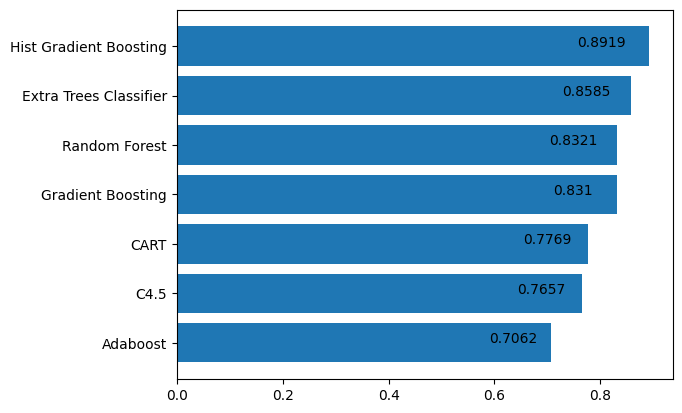

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()

df = pd.DataFrame(results)

df_sorted = df.sort_values('accuracy_score')

ax.barh('classifier', 'accuracy_score', data=df_sorted)
for i in range(len(results)):
    ax.text(results[i]['accuracy_score'] * 0.9, results[i]['classifier'], round(results[i]['accuracy_score'], 4), ha='center', color='black')


# Saving models

In [ ]:
# import pickle

# with open('et_classifier.pkl','wb') as f:
#     pickle.dump(et_classifier, f)
# with open('gb_classifier.pkl','wb') as f:
#     pickle.dump(gb_classifier, f)
# with open('hgb_classifier.pkl','wb') as f:
#     pickle.dump(hgb_classifier, f)
# with open('rf_classifier.pkl','wb') as f:
#     pickle.dump(rf_classifier, f)
# with open('ab_classifier.pkl','wb') as f:
#     pickle.dump(ab_classifier, f)

In [ ]:
# y_pred = hgb_classifier.predict_proba(X_test)
# y_pred

array([[0.43980933, 0.56019067],
       [0.82797224, 0.17202776],
       [0.01374955, 0.98625045],
       ...,
       [0.96816019, 0.03183981],
       [0.46740587, 0.53259413],
       [0.5749302 , 0.4250698 ]])